# Read data

In [5]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Paths to the data and correlation results
dirs = ["res6", "res8"]
names = ["MGS1_SD6", "MGS1_SD8"]
paths_data = [f"/mnt/c/Users/Elena/Desktop/Data_processing/020226_U2OS2_fixed_MGS1/{dir}/results.csv" for dir in dirs]
paths_corr = [f"/mnt/c/Users/Elena/Desktop/Data_processing/020226_U2OS2_fixed_MGS1/{dir}/spearman_pairs.csv" for dir in dirs]
# Load data and correlation results into dictionaries
dfs = {
    name: pd.read_csv(path)
    for name, path in zip(names, paths_data)
}
corrs = {
    name: pd.read_csv(path)
    for name, path in zip(names, paths_corr)
}

# Combine dataframes and add a 'Group' column
combined = []
for name, df in dfs.items():
    temp = df.copy()
    temp["Group"] = name
    combined.append(temp)
combined_df = pd.concat(combined, ignore_index=True)


# Graphs

## Separate boxplots

<Figure size 640x480 with 0 Axes>

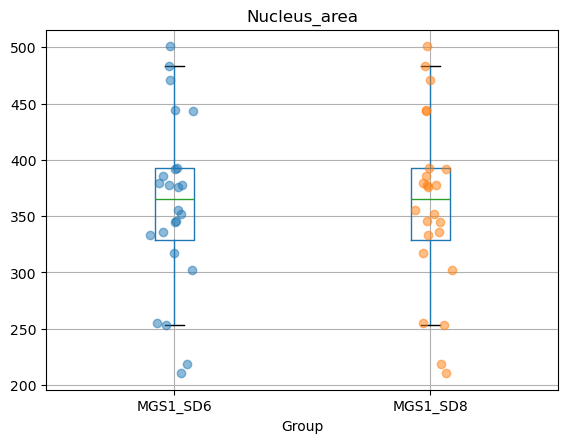

<Figure size 640x480 with 0 Axes>

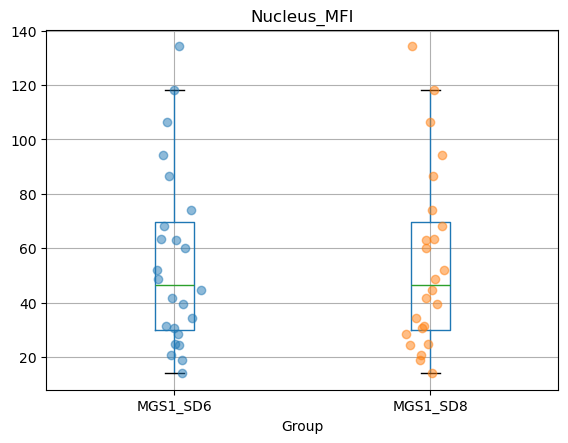

<Figure size 640x480 with 0 Axes>

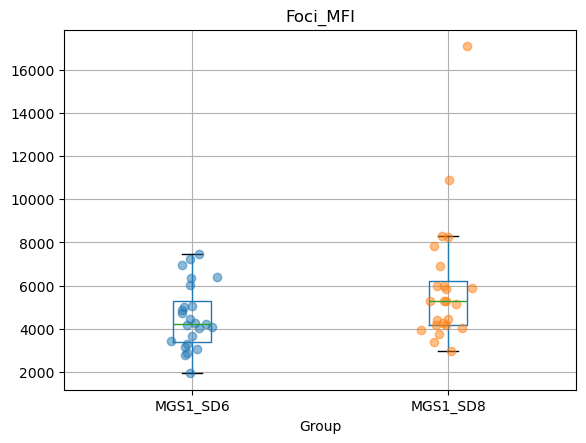

<Figure size 640x480 with 0 Axes>

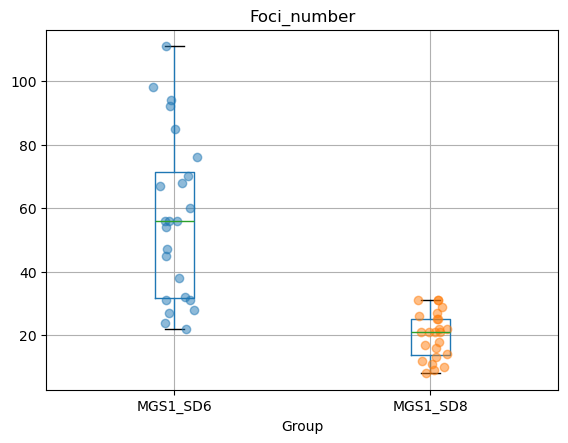

In [21]:
# Plot boxplots per variable
variables = ["Nucleus_area", "Nucleus_MFI", "Foci_MFI", "Foci_number"]
for var in variables:
    plt.figure()
    combined_df.boxplot(column=var, by="Group", showfliers=False)

    for i, group in enumerate(dfs.keys(), start=1):
        y = combined_df[combined_df["Group"] == group][var].dropna()
        x = np.random.normal(i, 0.04, size=len(y))
        plt.plot(x, y, "o", alpha=0.5)

    plt.title(var)
    plt.suptitle("")
    plt.show()

## One boxplot

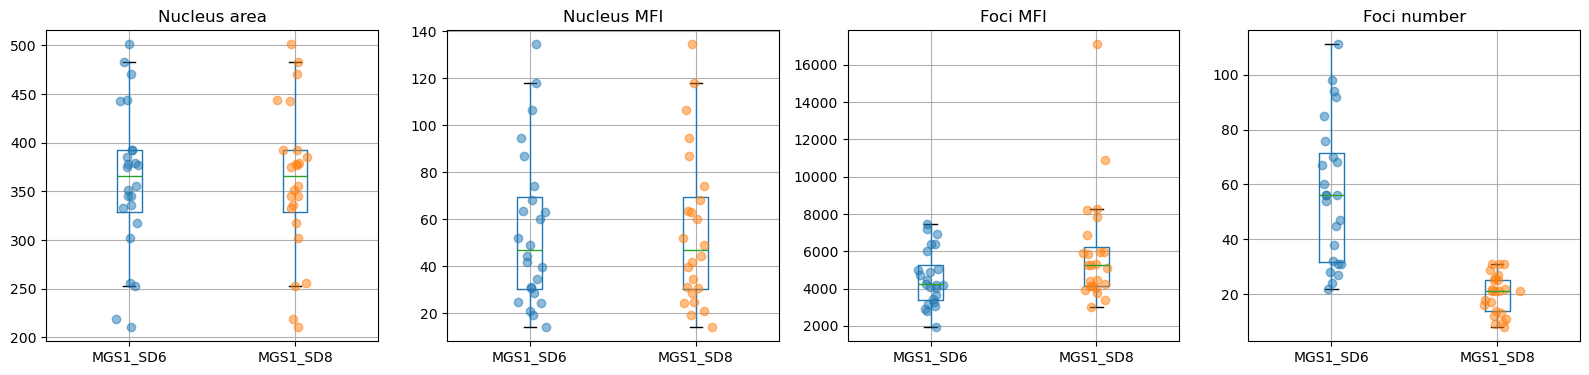

In [22]:
variables = ["Nucleus_area", "Nucleus_MFI", "Foci_MFI", "Foci_number"]
groups = list(dfs.keys())

fig, axes = plt.subplots(1, len(variables), figsize=(16, 4))

for ax, var in zip(axes, variables):

    # Boxplot
    combined_df.boxplot(
        column=var,
        by="Group",
        ax=ax,
        showfliers=False
    )

    # Jittered points
    for i, group in enumerate(groups, start=1):
        y = combined_df[combined_df["Group"] == group][var].dropna()
        x = np.random.normal(i, 0.04, size=len(y))
        ax.plot(x, y, "o", alpha=0.5)

    ax.set_title(var.replace("_", " "))
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("")
plt.tight_layout()
plt.show()


# Spearman correlation visualization

In [ ]:
col1 = "Foci_MFI"
col2 = "Foci_number"

plt.figure()
plt.scatter(data[col1], data[col2], alpha=0.6)
plt.xlabel(col1)
plt.ylabel(col2)
plt.tight_layout()
plt.show()